<a href="https://colab.research.google.com/github/tudi72/ECG_classification_AutoML/blob/main/27_septembrie_ecg_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# READING DATA

In [3]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import files
# url = "https://drive.google.com/file/d/1OCCO8WwHdse-hu7rE3yTAn3XjzusyFhY/view?usp=sharing"
uploaded = files.upload()

Saving data_8.csv to data_8.csv


In [5]:
import pandas as pd
df = pd.read_csv('data_8.csv')

print(df['Type'].value_counts())

0    76557
1    29107
Name: Type, dtype: int64


# SPLIT DATA into Train and Test

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [7]:
MLII_X = df.iloc[:,5:55].values
MLII_y = df['Type'].values.reshape(-1,1)

In [8]:
MLII_X_train, MLII_X_test, MLII_y_train, MLII_y_test = train_test_split(MLII_X, MLII_y, test_size=0.33, random_state=42)

In [9]:
import numpy as np
unique, counts = np.unique(MLII_y_test,return_counts=True)

print('Test - Healthy\t',counts[0],' Sick\t',counts[1])
unique, counts = np.unique(MLII_y_train,return_counts=True)
print('Train - Healthy\t',counts[0],' Sick\t',counts[1])


Test - Healthy	 25281  Sick	 9589
Train - Healthy	 51276  Sick	 19518


In [ ]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn
!pip install mljar-supervised
for _ in range(3):
    try:
        import autosklearn.classification
        break
    except:
        pass
else:
    raise ImportError("failed to import from autosklearn")

In [13]:
from autosklearn.classification import AutoSklearnClassifier

model = AutoSklearnClassifier(time_left_for_this_task=20*60,memory_limit= 30000)

model.fit(MLII_X_train,MLII_y_train)


[WARNING] [2022-09-27 17:47:59,978:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-09-27 17:50:01,241:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-09-27 17:52:02,669:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-09-27 17:54:03,937:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-09-27 17:56:05,187:Client-EnsembleBuilder] No runs were available to build an ensemble from


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      memory_limit=30000, per_run_time_limit=120,
                      time_left_for_this_task=1200)

In [14]:
MLII_y_pred = model.predict(MLII_X_test)

0.9436731946355027


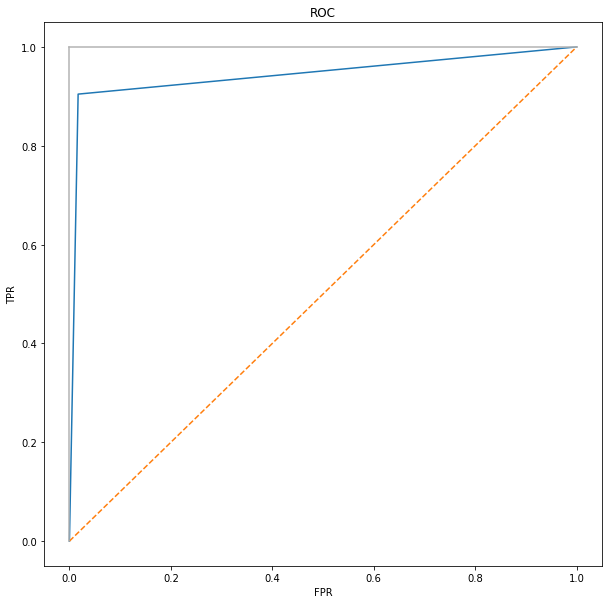

In [15]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt 

fpr, tpr, thresholds = roc_curve(MLII_y_test, MLII_y_pred)
print(auc(fpr, tpr))

plt.subplots(1, figsize=(10,10))
plt.title('ROC')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7")
plt.plot([1, 1] , c=".7")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [16]:
from sklearn.metrics import accuracy_score,confusion_matrix


print("Accuracy\t", accuracy_score(MLII_y_test, MLII_y_pred))
tn,fp,fn,tp = confusion_matrix(MLII_y_test,MLII_y_pred).ravel()
TPR = tp / (tp+fp)
FPR = fp / (fn + tn)

print('TP ', tp)
print('TN ', tn)
print('FP ', fp)
print('FN ', fn)
print('TPR\t\t',TPR)
print('FPR\t\t',FPR)


Accuracy	 0.9613134499569831
TP  8673
TN  24848
FP  433
FN  916
TPR		 0.9524489347682846
FPR		 0.016806396522279148


In [17]:
print(model.leaderboard())

          rank  ensemble_weight               type      cost   duration
model_id                                                               
8            1             0.66  gradient_boosting  0.038009  23.038678
9            2             0.02  gradient_boosting  0.046270  26.155966
11           3             0.32      random_forest  0.211103  93.546818


In [18]:
import sklearn.metrics
predictions = model.predict(MLII_X_train)
print("Accuracy score:", sklearn.metrics.accuracy_score(MLII_y_train, predictions))

Accuracy score: 0.9875554425516286
